<a href="https://colab.research.google.com/github/pankosmas/NLP-in-Mobile-Journalism/blob/main/notebooks/Topic_Modeling_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup and Installation
!pip install bertopic[visualization] umap-learn datamapplot -q
!pip install sentence-transformers -q

In [ ]:
# Step 2: Mount Google Drive and Load Data
from google.colab import drive
import pandas as pd
import json

In [ ]:
# Replace with your JSON file path in Google Drive
json_file_path = "/content/drive/MyDrive/datasets/news_articles_fixed.json"

In [ ]:
# Load data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    # Drop rows where 'text' is null, empty, or missing
    df = df[df['processed_text'].notnull() & (df['processed_text'].str.strip() != '')]
    return pd.DataFrame(data)

data = load_data(json_file_path)
print(data.head())

# Ensure data has the required columns: text, category, and timestamp
assert 'processed_text' in data.columns, "The dataset must have a 'text' column."
assert 'assigned_category' in data.columns, "The dataset must have a 'category' column."
assert 'timestamp' in data.columns, "The dataset must have a 'timestamp' column."

                                    _id     timestamp  \
0  {'$oid': '676b5b7aa14ed5ca0b6947d5'}  1.734498e+09   
1  {'$oid': '676b5b7aa14ed5ca0b6947d6'}  1.734504e+09   
2  {'$oid': '676b5b7aa14ed5ca0b6947d7'}  1.734608e+09   
3  {'$oid': '676b5b7aa14ed5ca0b6947d8'}  1.734606e+09   
4  {'$oid': '676b5b7aa14ed5ca0b6947d9'}  1.735035e+09   

                        assigned_category  \
0  Τέχνες, Πολιτισμός, Ψυχαγωγία και Μέσα   
1  Τέχνες, Πολιτισμός, Ψυχαγωγία και Μέσα   
2                              Περιβάλλον   
3  Τέχνες, Πολιτισμός, Ψυχαγωγία και Μέσα   
4  Τέχνες, Πολιτισμός, Ψυχαγωγία και Μέσα   

                                      processed_text  
0  κατέβα ουρανέ στη γη τα σκοτεινά μας βάραθρα ν...  
1  η σκηνή του 69ου διαγωνισμού τραγουδιού της eu...  
2  η παράσταση σύγχρονου χορού forage στο καλλιτε...  
3  ο barry jenkins ξέρει ότι απόρησες. και να μην...  
4  αν μία ταινία είναι άρρηκτα συνδεδεμένη με την...  


In [ ]:
# Step 3: Preprocessing - 9 minutes
import re
import os

# Define the path to save the preprocessed data
preprocessed_file_path = '/content/drive/MyDrive/datasets/preprocessed_data.csv'

# Custom stopwords list
custom_stopwords = ['αλλα', 'αλλά', 'εγω', 'εγώ', 'εσυ', 'εσύ', 'αυτος', 'αυτός', 'αυτη', 'αυτή', 'αυτο', 'αυτό', 'εμεις', 'εμείς', 'εσεις', 'εσείς', 'αυτοι', 'αυτοί', 'αυτα', 'αυτά', 'το', 'του', 'τα', 'των', 'τις', 'τους', 'τοις', 'και', 'ναι', 'οχι', 'μη', 'μην', 'δε', 'λίγο', 'λιγο', 'τόσο', 'τοσο', 'γι', 'για', 'δεν', 'ειμαι', 'είμαι', 'εισαι', 'είσαι', 'ειναι', 'είναι', 'ειμαστε', 'είμαστε', 'ειστε', 'είστε', 'ουτε', 'ούτε', 'μητε', 'μήτε', 'ουδε', 'ουδέ', 'η', 'ή', 'ειτε', 'είτε', 'αν', 'και', 'μα', 'παρα', 'πάρα', 'παρά', 'ομως', 'όμως', 'ωστοσο', 'ωστόσο', 'ενω', 'ενώ', 'μολονοτι', 'μολονότι', 'μονο', 'μόνο', 'μονό', 'που', 'λοιπον', 'λοιπόν', 'ωστε', 'ώστε', 'αρα', 'άρα', 'επομενως', 'επομένως', 'οποτε', 'όποτε', 'οπότε', 'δηλαδη', 'δηλαδή', 'οτι', 'ότι', 'πως', 'που', 'μην', 'μηπως', 'μήπως', 'να', 'αμα', 'άμα', 'οταν', 'όταν', 'καθως', 'καθώς', 'αφου', 'αφού', 'αφοτου', 'αφότου', 'πριν', 'μολις', 'προτου', 'ωσπου', 'ωσοτου', 'σαν', 'γιατι', 'διοτι', 'επειδη', 'αφου', 'τι', 'οτι', 'για', 'να', 'ωστε', 'ως', 'παρα', 'αναμεσα', 'κάνω', 'κάνεις', 'κάνει', 'κάνουν', 'κάνουμε', 'κι', 'δε', 'μέρα', 'μεταξυ', 'εαν', 'ανω', 'κατω', 'πανω', 'πισω', 'μπρος', 'μπροστα', 'εχω', 'κανω', 'λεω', 'βλεπω', 'μπορω', 'μπορει', 'ισως', 'καλα', 'καλο', 'καλος', 'καλη', 'καλων', 'καλους', 'καλε', 'εκει', 'εκτος', 'εντος', 'μεσα', 'εξω', 'ιδιο', 'ηταν', 'ζωη', 'ολα', 'ολο', 'ολος', 'ολοι', 'ομως', 'ποτε', 'σπανια', 'οποιος', 'οποια', 'οποιο', 'οποιους', 'οποιοι', 'οποιες', 'πολυ', 'πολλα', 'πολλη', 'πολλων', 'πολλους', 'τωρα', 'χθες', 'σημερα', 'αυριο', 'παρον', 'παρων', 'μελλον', 'παρελθον', 'ωρα', 'χωρις', 'με', 'χρονια', 'πρωτος', 'της', 'κατα', 'στα', 'στο', 'στη', 'στων', 'στις', 'στους', 'οι', 'ο', 'η', 'απο', 'στην', 'στη', 'στον', 'στο', 'τον', 'την', 'μόλις', 'προτού', 'ώσπου', 'ωσότου', 'σαν', 'γιατί', 'διότι', 'επειδή', 'αφού', 'τι', 'ότι', 'για', 'να', 'ώστε', 'ως', 'πάρα', 'αναμεσά', 'έχετε', 'κάνετε', 'χθες', 'χτες', 'εχτές', 'εχθέςμεταξύ', 'εάν', 'άνω', 'κάτω', 'πάνω', 'πίσω', 'μπρος', 'μπροστά', 'έχω', 'κάνω', 'λέω', 'βλέπω', 'μπορώ', 'μπορεί', 'ίσως', 'καλά', 'καλό', 'καλός', 'καλή', 'καλών', 'καλούς', 'καλέ', 'εκεί', 'εκτός', 'εντός', 'μέσα', 'έξω', 'ίδιο', 'ήταν', 'ζωή', 'μεγάλη', 'μικρή', 'όλα', 'όλο', 'όλος', 'όλοι', 'όμως', 'ποτέ', 'σπάνια', 'όποιος', 'όποια', 'όποιο', 'όποιους', 'όποιοι', 'όποιες', 'πολύ', 'πολλά', 'πολλή', 'πολλών', 'πολλούς', 'τώρα', 'χθες', 'σήμερα', 'αύριο', 'παρόν', 'παρών', 'μέλλον', 'παρελθόν', 'ώρα', 'χωρίς', 'με', 'χρονιά', 'πρώτος', 'της', 'κατά', 'στα', 'στο', 'στη', 'στων', 'στις', 'στους', 'οι', 'ο', 'η', 'από', 'στην', 'στη', 'στον', 'στο', 'τον', 'την', 'θα', 'όμως', 'σε', 'αυτού', 'τη', 'όλους', 'μας', 'σας', 'πρέπει', 'ήδη', 'έχει', 'είχε', 'μια', 'μία', 'ένα', 'ένας', 'ενός', 'υπό', 'οποία', 'οποίο', 'οποίος', 'οποίους', 'δικό', 'μετά', 'κοντά', 'έως', 'εώς', 'άλλους', 'κάτι', 'γύρω', 'πιο', 'όσο', 'έχουν', 'μπορώ', 'μπορεί', 'μπορείτε', 'μπορούν', 'πάνε', 'κάντε', 'δικό', 'θέλετε', 'δώσετε', 'προς', 'όπως', 'δώστε', 'δει', 'δείτε', 'βλέπω', 'έτσι', 'άλλοι', 'ίδια', 'νέα', 'πολλά', 'κυρίως', 'άλλη', 'ακόμα', 'οποίων', 'επί', 'είπε', 'όχι', 'μέχρι', 'μου', 'σου', 'του', 'δυο', 'δύο', 'πλέον', 'είπε', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'αυτ', 'όλη', 'όσους', 'όλες', 'αυτούς', 'θέλω', 'βάζω', 'κάθε', 'κά', 'τότε', 'έχουμε', 'θέλει', 'έκανε', 'βρίσκεται', 'ακόμη', 'όπου', 'φέτος', 'πέρσι', 'μετά', 'πέρυσι', 'πήρε', 'έδωσε', 'ης', 'βγει', 'νέος', 'νέα', 'νέοι', 'νέους', 'νέας', 'νέων', 'ος', 'γίνει', 'υπάρχει', 'υπάρχω', 'υπάρχουν', 'πάλι', 'θέμα', 'πώς', 'ανεξαρτήτως', 'ίδιος', 'μάλιστα', 'έναν', 'έγινε', 'άλλο', 'τρία', 'τρια', 'τρείς', 'τρεις', 'πέντε', 'έξι', 'επτά', 'οκτώ', 'δέκα', 'τέσσερις', 'θεμα', 'ετ', 'κεδ', 'εναντίον', 'τέσσερα', 'αε', 'ίδιες', 'σ', 'ς', 'εννέα', 'εννιά', 'αο', 'γς', 'τέλος', 'πάντως', 'επίσης', 'ας', 'πχ', 'x', 'εκ', 'περί', 'αυτές', 'άλλων']

# Check if the preprocessed file exists
if os.path.exists(preprocessed_file_path):
    print("Loading preprocessed data from file...")
    data = pd.read_csv(preprocessed_file_path)
else:
    print("Preprocessing data...")

    def preprocess_text(text):
        if not isinstance(text, str):  # Check if the text is a valid string
            return ""
        text = re.sub(r'[\W_]+', ' ', text)  # Remove special characters
        text = ' '.join(word for word in text.split() if word.lower() not in custom_stopwords)
        return text

    # Ensure 'processed_text' exists; fallback to 'text' if necessary
    if 'processed_text' in data.columns:
        data['cleaned_text'] = data['processed_text'].apply(preprocess_text)
    elif 'text' in data.columns:
        data['cleaned_text'] = data['text'].apply(preprocess_text)
    else:
        raise ValueError("The dataset must have a 'processed_text' or 'text' column.")

    # Save the preprocessed data to a file
    data.to_csv(preprocessed_file_path, index=False)
    print(f"Preprocessed data saved to {preprocessed_file_path}")

# Display cleaned text
print(data[['processed_text', 'cleaned_text']].head() if 'processed_text' in data.columns else data[['text', 'cleaned_text']].head())

Loading preprocessed data from file...
                                      processed_text  \
0  κατέβα ουρανέ στη γη τα σκοτεινά μας βάραθρα ν...   
1  η σκηνή του 69ου διαγωνισμού τραγουδιού της eu...   
2  η παράσταση σύγχρονου χορού forage στο καλλιτε...   
3  ο barry jenkins ξέρει ότι απόρησες. και να μην...   
4  αν μία ταινία είναι άρρηκτα συνδεδεμένη με την...   

                                        cleaned_text  
0  κατέβα ουρανέ γη σκοτεινά βάραθρα φέξεις αβάστ...  
1  σκηνή 69ου διαγωνισμού τραγουδιού eurovision έ...  
2  παράσταση σύγχρονου χορού forage καλλιτεχνικό ...  
3  barry jenkins ξέρει απόρησες πάει εξαρχής μυαλ...  
4  ταινία άρρηκτα συνδεδεμένη περίοδο χριστουγένν...  


In [ ]:
# Step 4: Sentence Transformer Selection
from sentence_transformers import SentenceTransformer

# Choose a Greek-specific or multilingual model
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
!pip install gensim

In [ ]:
# Step 5: Hyperparameter Tuning - 6 MINUTES PER MODEL
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import ParameterGrid

# Keep only rows where 'cleaned_text' is a string
data = data[data['cleaned_text'].apply(lambda x: isinstance(x, str))]

# Reset index after filtering
data = data.reset_index(drop=True)

def calculate_coherence(model, documents):
    """
    Calculate topic coherence using Gensim's CoherenceModel.

    Parameters:
        model (BERTopic): A fitted BERTopic model.
        documents (list of str): List of input documents.

    Returns:
        float: Coherence score.
    """
    # Extract topics as a list of lists of words
    topics = model.get_topics()
    top_words_per_topic = [[word for word, _ in words] for words in topics.values() if words]

    # Debugging: Print a sample of the extracted topics
    print(f"Sample topics: {topics}")

    # Tokenize documents
    tokenized_docs = [doc.split() for doc in documents]

    # Create a Gensim dictionary
    dictionary = Dictionary(tokenized_docs)
    # dictionary.filter_extremes(no_below=5, no_above=0.5)
    dictionary.filter_extremes(no_below=1, no_above=1.0)

    top_words_per_topic_in_ids = [
        [dictionary.token2id[word] for word in topic if word in dictionary.token2id]
        for topic in top_words_per_topic
    ]

    # Debugging: Print the dictionary size and first few tokens
    print(f"Dictionary size: {len(dictionary)}")
    print(f"Sample dictionary tokens: {list(dictionary.token2id.items())[:5]}")

    # Use Gensim's CoherenceModel
    coherence_model = CoherenceModel(
        topics=top_words_per_topic_in_ids,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()


def topic_diversity(topics, top_k=10):
    # Flatten top-k words from all topics
    unique_words = set()
    total_words = 0
    for topic in topics.values():
        words = [word for word, _ in topic[:top_k]]
        unique_words.update(words)
        total_words += len(words)
    return len(unique_words) / total_words


# Define a grid of hyperparameters
param_grid = {
    'vectorizer_ngram_range': [(1, 2)],
    'umap_n_neighbors': [5], # [5, 15],
    'umap_min_dist': [0.1], # [0.1, 0.5],
    'hdbscan_min_cluster_size':[20], # [5, 10, 20],
    'hdbscan_min_samples': [5], # [1, 5],
    'bertopic_nr_topics': [None], # 20, 50
}

# Create parameter grid
grid = ParameterGrid(param_grid)

# Variables to track the best model and scores
best_model = None
best_coherence = -1
best_diversity = -1
best_params = {}

# Log file to track results
log_file = '/content/drive/MyDrive/datasets/bertopic_tuning_log.txt'
with open(log_file, 'w') as log:
    log.write("Hyperparameter Tuning Results\n")
    log.write("---------------------------------\n")

# Iterate over all combinations of parameters
for params in grid:
    # Update Vectorizer
    vectorizer_model = CountVectorizer(
        min_df=1,
        max_df=0.85,
        ngram_range=params['vectorizer_ngram_range'],
        stop_words=custom_stopwords
    )

    # Update UMAP
    umap_model = UMAP(
        n_neighbors=params['umap_n_neighbors'],
        min_dist=params['umap_min_dist'],
        n_components=2,
        metric='cosine'
    )

    # Update HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=params['hdbscan_min_cluster_size'],
        min_samples=params['hdbscan_min_samples']
    )

    # Initialize BERTopic
    bertopic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics=params['bertopic_nr_topics'],
        calculate_probabilities=False,
        language="greek"
    )

    # Fit the model
    topics, _ = bertopic_model.fit_transform(data['cleaned_text'])

In [ ]:
    # Evaluate coherence and diversity
    coherence_score = calculate_coherence(bertopic_model, data['cleaned_text'])
    diversity_score = topic_diversity(bertopic_model.get_topics())

    # Log results
    with open(log_file, 'a') as log:
        log.write(f"Params: {params}\n")
        log.write(f"Coherence Score: {coherence_score}\n")
        log.write(f"Diversity Score: {diversity_score}\n")
        log.write("---------------------------------\n")

    # Save the best model based on coherence score
    if coherence_score > best_coherence:
        best_model = bertopic_model
        best_coherence = coherence_score
        best_diversity = diversity_score
        best_params = params

# Print the best hyperparameters and evaluation scores
print(f"Best Parameters: {best_params}")
print(f"Best Coherence Score: {best_coherence}")
print(f"Best Diversity Score: {best_diversity}")

In [ ]:
# Save the best model
best_model = bertopic_model
best_model.save("/content/drive/MyDrive/datasets/bertopic_best_model")

2024-12-30 05:00:44,729 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Batches:   0%|          | 0/2349 [00:00<?, ?it/s]

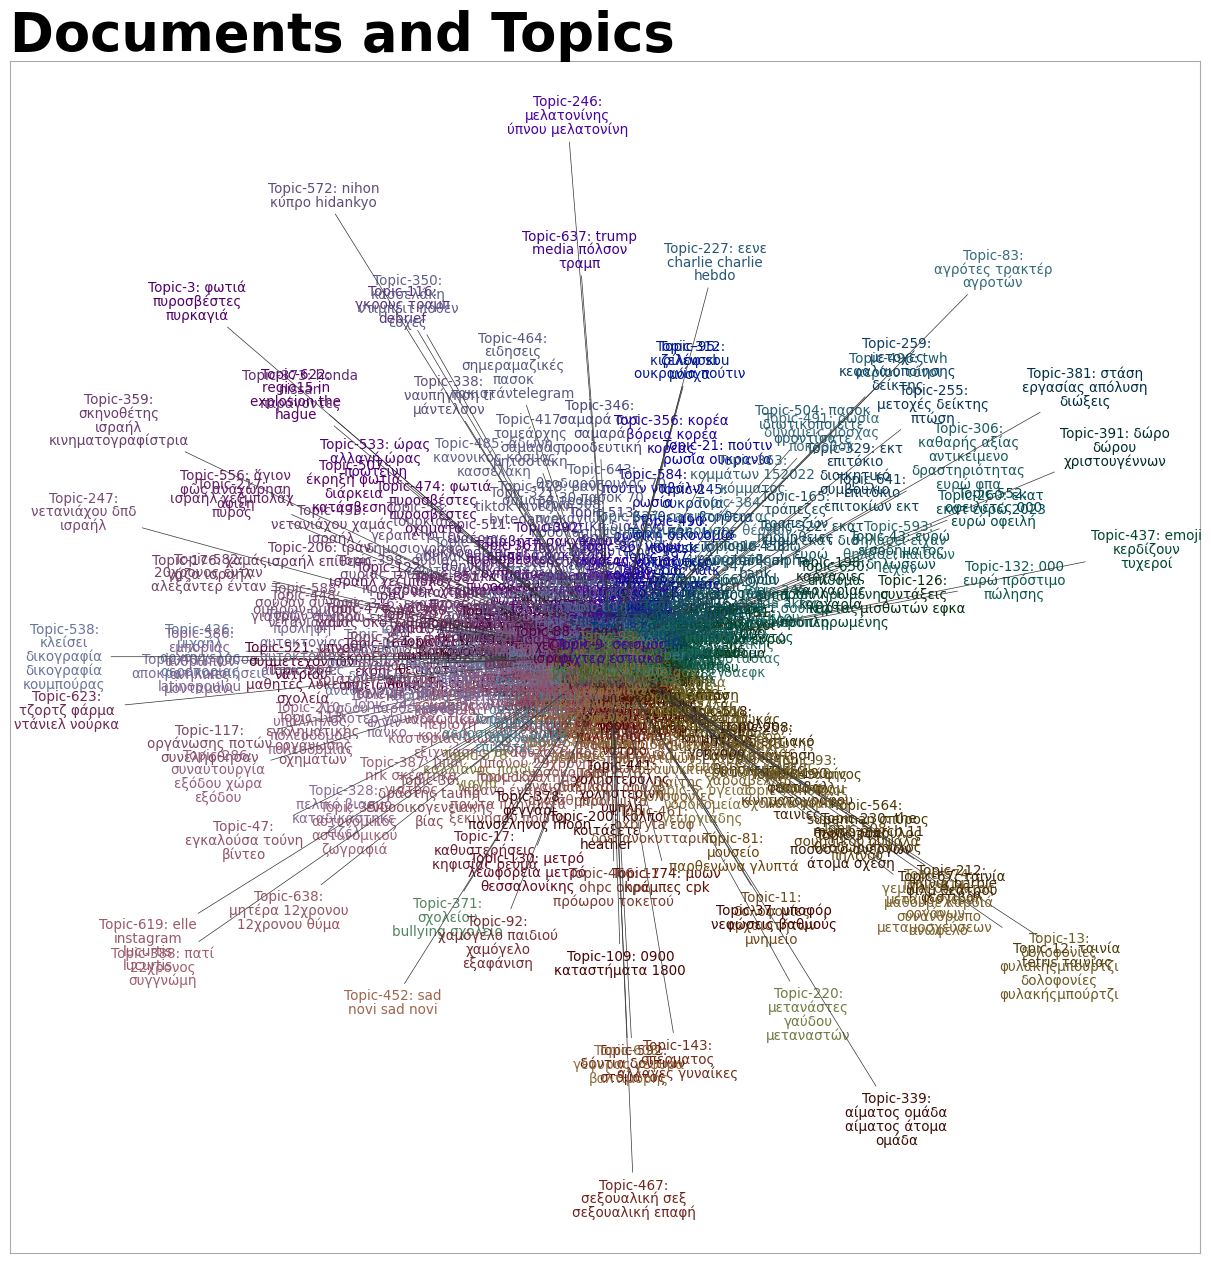

In [ ]:
# Step 6: Visualizations
import os
import matplotlib.pyplot as plt
import matplotlib
from datamapplot import create_plot

# Set the font to a Greek-compatible font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # Ensure minus signs are displayed properly

visualization_dir = "/content/drive/MyDrive/datasets/bertopic_visualizations"
os.makedirs(visualization_dir, exist_ok=True)

# UMAP visualization
fig_umap = best_model.visualize_documents(data['cleaned_text'], topics=best_model.get_topics())
fig_umap.write_html(f"{visualization_dir}/umap_visualization.html")

# Other visualizations
fig_topics = best_model.visualize_topics()
fig_topics.write_html(f"{visualization_dir}/topics_visualization.html")

fig_barchart = best_model.visualize_barchart()
fig_barchart.write_html(f"{visualization_dir}/barchart_visualization.html")

fig_heatmap = best_model.visualize_heatmap()
fig_heatmap.write_html(f"{visualization_dir}/heatmap_visualization.html")

# Datamap visualization
# Use the same UMAP parameters as in the BERTopic model
embeddings = embedding_model.encode(data['cleaned_text'], show_progress_bar=True)
umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine')
reduced_embeddings = umap_model.fit_transform(embeddings)
fig_datamap = best_model.visualize_document_datamap(data['cleaned_text'], reduced_embeddings=reduced_embeddings, font_family="DejaVu Sans")
fig_datamap.savefig(f"{visualization_dir}/datamap_visualization.png", bbox_inches="tight", dpi=300)

In [ ]:
# Step 7: Dynamic Topic Modeling
# Add timestamp information
import pandas as pd

# Separate text and timestamps
texts = data['cleaned_text'].to_list()
timestamps = data['timestamp'].to_list()
topics_over_time = best_model.topics_over_time(texts, timestamps)

# Visualize topics over time
fig_over_time = best_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)
fig_over_time.write_html(f"{visualization_dir}/topics_over_time_visualization.html")

2024-12-30 05:52:57,051 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 67366) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


In [ ]:
# Step 8: Save Results
# Save topics and probabilities
data['topic'] = best_model.get_document_info(data['cleaned_text'])['Topic']
data.to_csv('/content/drive/MyDrive/datasets/topic_model_results.csv', index=False)

# Save BERTopic model
best_model.save("/content/drive/MyDrive/datasets/bertopic_model")

# Print final topics info
print(best_model.get_topic_info())

2024-12-30 04:35:47,205 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


    Topic  Count                                             Name  \
0      -1    513              -1_ταινία_φεστιβάλ_τραγούδι_μουσική   
1       0    433            0_μουσική_τραγούδια_μουσικής_τραγούδι   
2       1    278         1_αστυνομία_δικαστήριο_κατηγορίες_πελικό   
3       2    225                 2_survivor_παίκτες_μπλε_παιχνίδι   
4       3    152             3_ισραήλ_χεζμπολάχ_λίβανο_νετανιάχου   
5       4    141                4_ουκρανία_ρωσία_πούτιν_ουκρανίας   
6       5    130           5_eurovision_σάττι_μαρίνα_μαρίνα σάττι   
7       6    114         6_τραμπ_ντόναλντ_ντόναλντ τραμπ_πρόεδρος   
8       7    112                 7_εκπομπή_ηθοποιός_είχα_εκπομπής   
9       8    107                          8_συρία_άσαντ_αλ_συρίας   
10      9     95                  9_ταινία_ταινίες_ταινίας_νομίζω   
11     10     89                        10_εκπομπή_ήμουν_ye_παιδί   
12     11     76                 11_σειράς_mega_famagusta_maestro   
13     12     67              12_m